Libraries

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Load image

In [3]:
#2 & 3 & High images are in jpeg format but, 1 & 1363 & 1929 image is in jpg format
image = cv2.cvtColor(cv2.imread("High.jpeg"),cv2.COLOR_BGR2RGB)
#you should generally use RGB representation. because RGB corresponds to the way humans see and describe colors in the real world
# RGB allows PCA to capture color and brightness variations in a way that aligns with human perception.

Split it to Red and Green and Blue channels

In [4]:
r, g, b = cv2.split(image)

Normalization and Centering data

In [5]:
#STEP 1
def Norm_cent(channel):
    channel = channel / 255.0
    mean= np.mean(channel,axis=0)
    Normalized_Centered_channel =channel-mean
    
    return Normalized_Centered_channel,mean

r,rmean= Norm_cent(r)
g,gmean= Norm_cent(g)
b,bmean= Norm_cent(b)

Defining PCA (reduction then reconstruction) for each channel indiviually to k dimenstions

In [6]:
def PCA(channel,k,mean):
    #STEP 2    
    covariance_matrix = np.cov(channel, rowvar=False) #false because samples in rows, and featuers or dimensions in columns. 
    
    #STEP 3
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    
    idx = np.argsort(eigenvalues)[::-1] # get indices in ascending and then flip it by(-1) to be in descending order
    eigenvalues = eigenvalues[idx] # do the actual sort for vals
    eigenvectors = eigenvectors[:, idx] #sort for vectors by indices

    
    k_eigenvectors = eigenvectors[:, :k] #get best k eigenvector

    #STEP 4 
    reduced_image = np.dot(channel, k_eigenvectors)# reduct columns of image

    #STEP 5
    reconstructed_image = np.dot(reduced_image, k_eigenvectors.T) + mean #we need mean to reposionate the data in itis actual place (UNDO centering)

    return reduced_image, reconstructed_image


Applying PCA on each channel

In [7]:
k = 50  
r_reduced, r_reconstructed = PCA(r, k,rmean)
g_reduced, g_reconstructed = PCA(g, k,gmean)
b_reduced, b_reconstructed = PCA(b, k,bmean)

Merging Channels to build the image

In [8]:
reduced_image = cv2.merge([r_reduced, g_reduced, b_reduced])
reconstructed_image = cv2.merge([r_reconstructed, g_reconstructed, b_reconstructed])

Plot images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


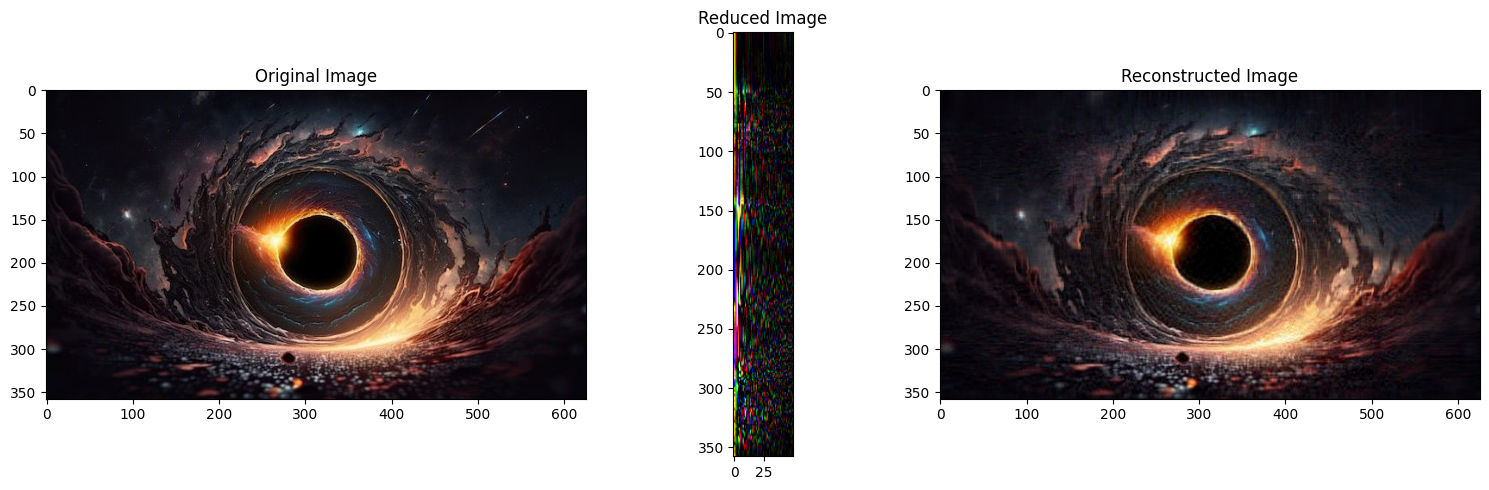

In [9]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)# one row, 3 columns, first subplot
plt.imshow(image)
plt.title('Original Image')
plt.subplot(1, 3, 2)# one row, 3 columns, second subplot
plt.imshow(reduced_image)
plt.title('Reduced Image')
plt.subplot(1, 3, 3)# one row, 3 columns, third subplot
plt.imshow(reconstructed_image)
plt.title('Reconstructed Image')
plt.tight_layout()# make the plots fit nicely in the plotting area
plt.show()

#Some values will be negative due to PCA but it will be replaced by lower limit whch is 0
# performing PCA make you lose some information and it is one of ways of loosing information while projecting to new axises 


**EIGEN FACES PROBLEM**

Get images paths

In [10]:
import os
'''
Here i will iterate over all folders in my data folder
and get all images paths and save them in one list  
'''
def recurse_img_path(directory):


  image_file_paths = []

  for root, directories, files in os.walk(directory):
    for file in files:
      if file.endswith(".jpg"):
        image_file_paths.append(os.path.join(root, file))

  for directory in directories:
    image_file_paths.extend(recurse_img_path(directory))

  return image_file_paths

images_paths  = recurse_img_path("eigen_face")
print(len(images_paths ), images_paths [0])

13233 eigen_face\Aaron_Eckhart\Aaron_Eckhart_0001.jpg


Load images

In [11]:

import cv2
import numpy as np

#num images to load
N = 6000

X = np.array([cv2.imread(image_path, 0).reshape(-1) for image_path in images_paths[0:N]])
Y = np.array([os.path.basename(os.path.dirname(image_path)) for image_path in images_paths[0:N]])

print(X.shape, Y.shape)
# 10000 image, each one image has 62500 pixels



(6000, 62500) (6000,)


Get rid of 1-sample classes

In [12]:
# getting rid of 1 sample class let the PCA focus on repeated samples getting better results
p_indexs = list(range(0, Y.shape[0]))
for name, count in np.array(np.unique(Y, return_counts=True)).T:
    if count == '1':
        index = np.where(Y==name)[0]
        p_indexs.remove(index[0])

print("Shape Before removing 1 sample class", X.shape, Y.shape)        
X = X[p_indexs]
Y = Y[p_indexs]
print("Shape After removing 1 sample class", X.shape, Y.shape) 

Shape Before removing 1 sample class (6000, 62500) (6000,)
Shape After removing 1 sample class (4239, 62500) (4239,)


Applying PCA "previously implemented" inside a function that output Eigen Faces 

In [13]:
def EigenFaces(X,k):
    x= X.T #to put in shape (num_of_pixels,num_of_images) because my manually implemented PCA reduct the second dimension
    
    #ceter data
    xmean = np.mean(x,axis=0)
    x = x-xmean
    reduced,reconstruted= PCA(x,k,xmean)
    reduced = reduced.T # to put it in shape(k,num_of_pixels=62500)
    
    reconstruted = reconstruted.T.reshape(X.shape[0],250,250)
    eigenfaces = reduced.reshape((k, 250, 250)) # 250*250 = 62500 
    
    return eigenfaces,reconstruted


Get Eigen Faces

In [14]:
k=100 # reduce it from 
eigenfaces_100 , reconstructed_faces_100 = EigenFaces(X,k)

In [15]:
k=200
eigenfaces_200 , reconstructed_faces_200= EigenFaces(X,k)

In [16]:
k=500
eigenfaces_500 , reconstructed_faces_500  = EigenFaces(X,k)

In [17]:
k=1000
eigenfaces_1000 , reconstructed_faces_1000 = EigenFaces(X,k)

In [18]:
print(eigenfaces_100.shape,reconstructed_faces_100.shape)

(100, 250, 250) (4239, 250, 250)


Plot Eigen Faces 'Reduced images'

In [19]:
import matplotlib.pyplot as plt

# function to plot a number of images as a gallery

def plot_as_gallery(images, h, w, n_row, n_col):
    
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.title("Eigen Face %s" % str(i + 1))
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.xticks(())
        plt.yticks(())




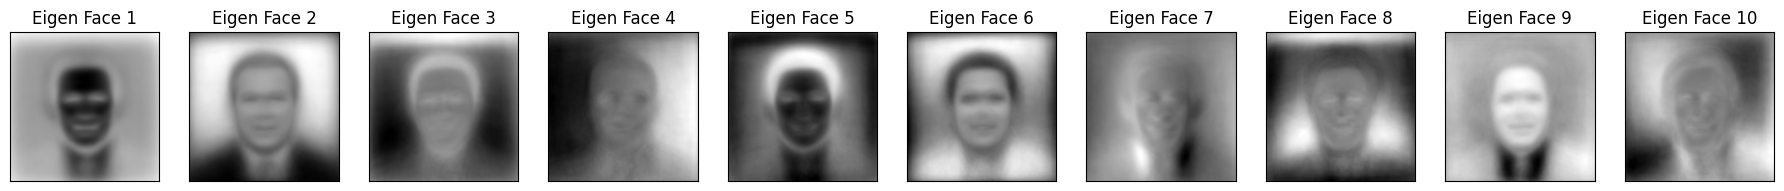

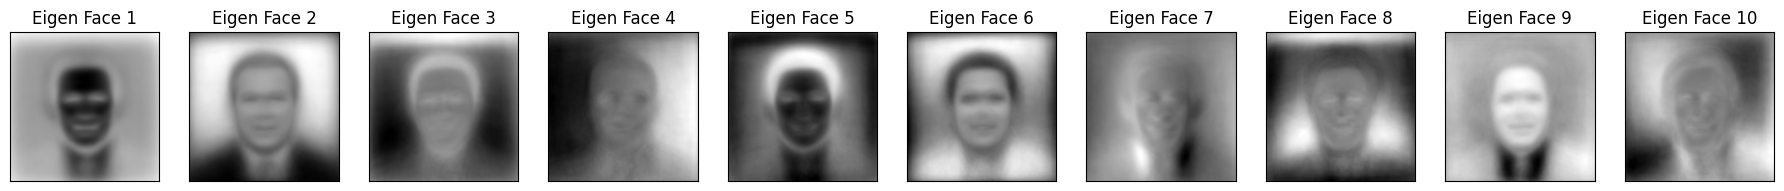

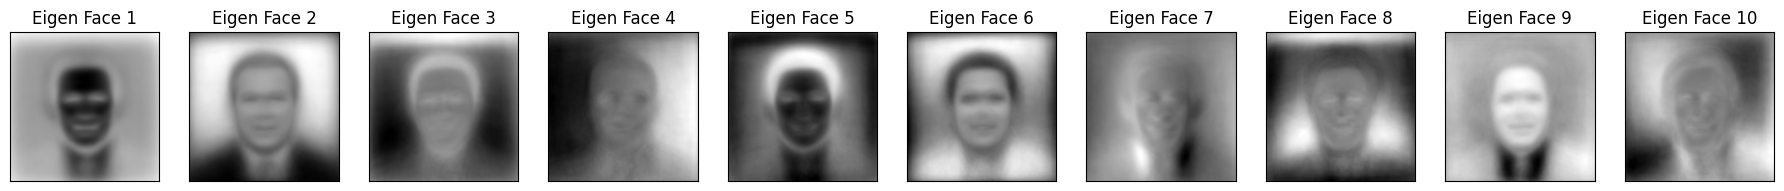

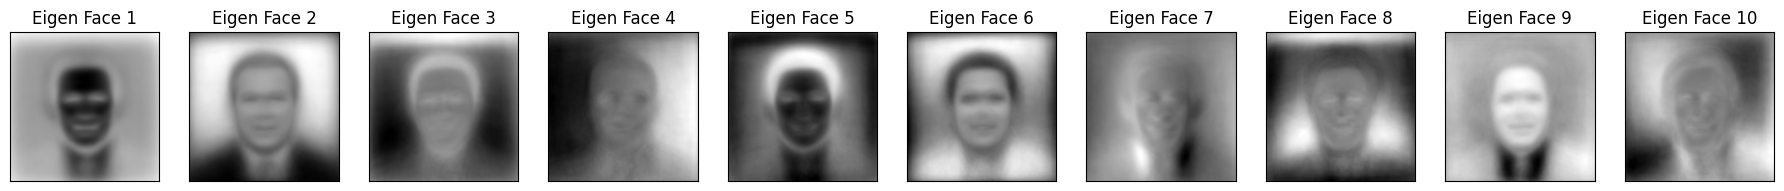

In [20]:
plot_as_gallery(eigenfaces_100[0:10], 250, 250, n_row=1, n_col=10)# to plot all eigen faces: increase n_row variable
plot_as_gallery(eigenfaces_200[0:10], 250, 250, n_row=1, n_col=10)# to plot all eigen faces: increase n_row variable
plot_as_gallery(eigenfaces_500[0:10], 250, 250, n_row=1, n_col=10)# to plot all eigen faces: increase n_row variable
plot_as_gallery(eigenfaces_1000[0:10], 250, 250, n_row=1, n_col=10)# to plot all eigen faces: increase n_row variable

Plot one of reconstructed Eigen Faces

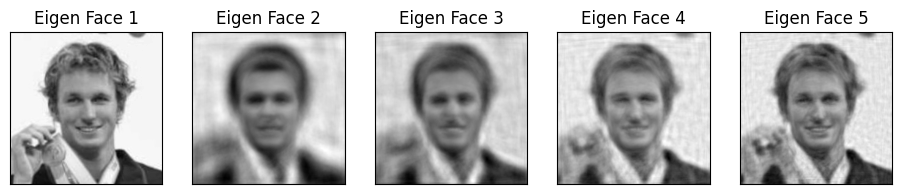

In [21]:
Face=[] #list to store the images from different k_dimensions reduced and reconstruted by pca
Face.append(X[0])
Face.append(reconstructed_faces_100[0]) 
Face.append(reconstructed_faces_200[0]) 
Face.append(reconstructed_faces_500[0]) 
Face.append(reconstructed_faces_1000[0]) 

plot_as_gallery(Face, 250, 250, n_row=1, n_col=5)